In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from pandas import Series
from numpy import log

In [2]:
dataset = pd.read_csv('/Users/pawankumarkc/Documents/vscode_workspace/MLAlgo/datasets/TSForecasting/airline_passengers.csv')

In [3]:
dataset.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [5]:
## Cannot have missing values
## Dateneed to be in ordered format


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
#Month column is object datatype, need to convert to datetime
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [8]:
# IN TSF, 2 variables are important
# 1. Time
# 2. Variable what we want to predict


<Axes: >

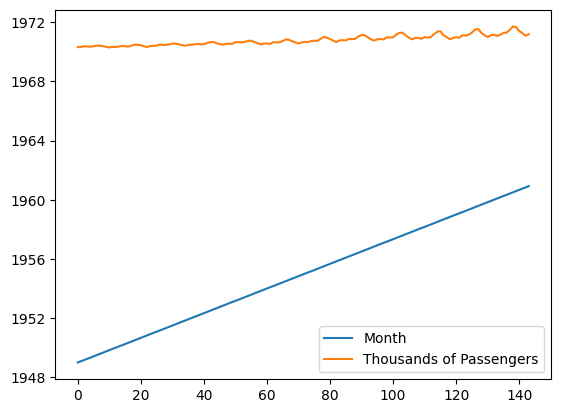

In [9]:
dataset.plot()

In [10]:
#Convert time to index, because time is the key for prediction in TSF
#Here, convert Month column to index

dataset.set_index('Month', inplace=True)

<Axes: xlabel='Month'>

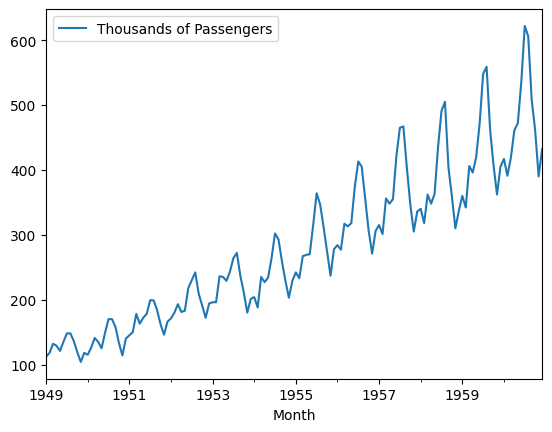

In [11]:
dataset.plot()

There is a upward trend (Multiplicative)
Long term data available
Need to check for error, seasonality, 

In [12]:
dataset.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Decomposition

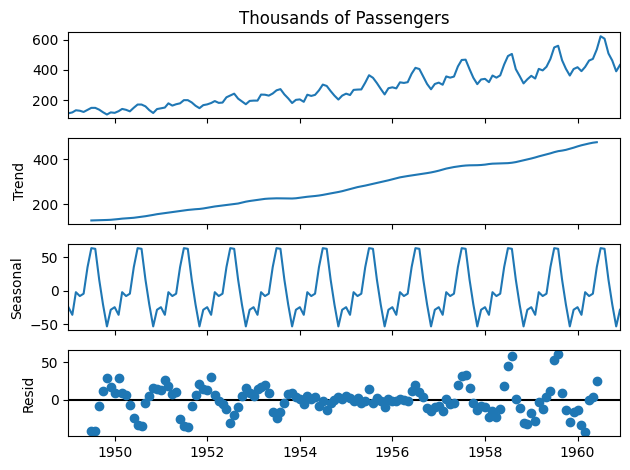

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(dataset['Thousands of Passengers'], model='additive', period=12)
decompose.plot()
plt.show()

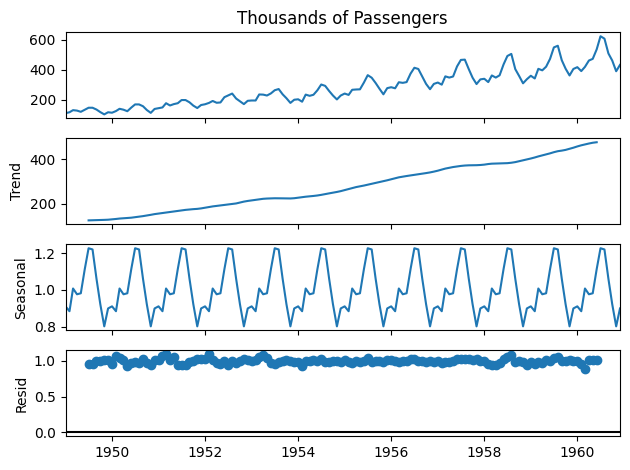

In [14]:
decompose = seasonal_decompose(dataset['Thousands of Passengers'], model='multiplicative', period=12)
decompose.plot()
plt.show()

#### From above datapoints, this is a additive model 

Derbin watson test - Result analysis
2 = No auto correlation (If value is 2, then it is not a time series problem)
less than 2 = Positive autocorrelation
more than 2 = Negative autocorrelation

### Check auto correlation using derbin watson test - !! Mandatory for TSA !!

In [15]:
#Derbin watson test
import statsmodels.api as sm
sm.stats.durbin_watson(dataset['Thousands of Passengers'])

0.0121527966037621

In [16]:
# Derbin watson test value is less 2, so it is a time series problem. 
# This dataset follows positive auto correlation

In [17]:
# We can only build time series, only when data is "Stationary", 
# if data is non-stationary we need to convert to stationary and then build the model

# Stationary data if p value is 0.05
# Eg: If temp, in my city every jan,Feb every year is 5 degree, then that is a stationary data
# Stationary data should have constant mean, sd, variance

#### Augumented Dickly fuller test

In [18]:
# Check data is stationary/non-stationary - Augumented Dickly fuller test
# Rolling methos - alternative for Augumented Dickly fuller 

from statsmodels.tsa.stattools import adfuller
adfuller(dataset['Thousands of Passengers'])

(0.8153688792060447,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [19]:
def stationarity(timeseries):
    result = adfuller(timeseries)
    print('Augumented Dickly Fuller test - Check for Stationary data')
    labels = ['ADF Test stats', 'P value', '#Lags', 'No. of Observations' ]

    for i, j in zip(result, labels):
        print(j, str(i))

    if result[1] < 0.05: # Checking P value
        print('Strong evidance against Null hypothesis and my timeseries is stationary')
    else:
        print('Weak evidance against Null hypothesis and my timeseries is non - stationary')


In [20]:
stationarity(dataset['Thousands of Passengers'])

Augumented Dickly Fuller test - Check for Stationary data
ADF Test stats 0.8153688792060447
P value 0.9918802434376409
#Lags 13
No. of Observations 130
Weak evidance against Null hypothesis and my timeseries is non - stationary


In [21]:
# If data is Non-stationary, use lag approach to make it stationary
# Lag = 1 step ahead and then find difference 
# To make Stationary = Apply integrated method (Lagging mathod)

In [22]:
dataset['1st diff'] = dataset['Thousands of Passengers'] - dataset['Thousands of Passengers'].shift(1)
dataset.head()

,Thousands of Passengers,1st diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [23]:
stationarity(dataset['1st diff'].dropna())

Augumented Dickly Fuller test - Check for Stationary data
ADF Test stats -2.8292668241699794
P value 0.054213290283828236
#Lags 12
No. of Observations 130
Weak evidance against Null hypothesis and my timeseries is non - stationary


In [24]:
# Data is still non-stationary. Move one step ahead, add 2nd diff

dataset['2nd diff'] = dataset['1st diff'] - dataset['1st diff'].shift(1)

In [25]:
dataset.head()

,Thousands of Passengers,1st diff,2nd diff
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [26]:
stationarity(dataset['2nd diff'].dropna())

Augumented Dickly Fuller test - Check for Stationary data
ADF Test stats -16.38423154246855
P value 2.732891850013928e-29
#Lags 11
No. of Observations 130
Strong evidance against Null hypothesis and my timeseries is stationary


In [27]:
# Now the dataset is good to build trend model. Similar we need to do check for seasonality
# d = 2
# parameter = p d q (Trend)

### Calculating Seasonality

In [28]:
# Calculating difference of 12 months to get seasonality
dataset['Seasonality'] = dataset['Thousands of Passengers'] - dataset['Thousands of Passengers'].shift(12)

In [29]:
stationarity(dataset['Seasonality'].dropna())

Augumented Dickly Fuller test - Check for Stationary data
ADF Test stats -3.3830207264924805
P value 0.011551493085514982
#Lags 1
No. of Observations 130
Strong evidance against Null hypothesis and my timeseries is stationary


In [30]:
# Trend : 
# p:
# d: 2 (No. of attempts taken to get nominal p value)
# q:

# Seasonality
# P:
# D: 1
# Q:

#How to calculate P/p and Q/q
# P = Partial autocorrelation, use autoregressive method and
# Q = we have to calculate basis of moving average. It is also called auto correlation

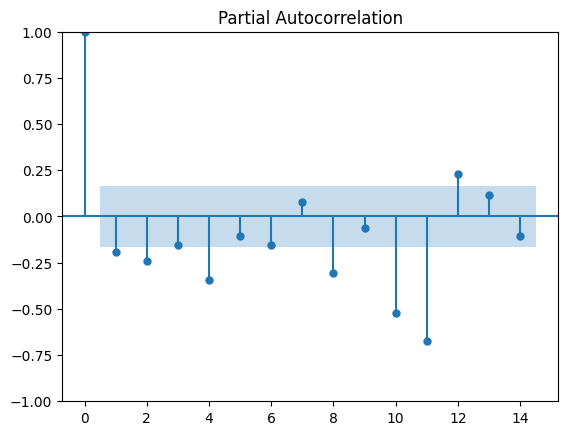

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#acf = auto corelation
#pacf = partial auto correlation

# p and P value
# p : Trend

plot_pacf(dataset['2nd diff'].dropna(), lags=14)
plt.show()

#Actual correlation value -1 to +1
# We have the data with in specified range

In [32]:
# Trend : 
# p: 4 (No. of lines in partial auto correlation crossing the threshold. Thres = Blue ribbon. Stop counting the moment the first line falls below ribbon)
# d: 2 (No. of attempts taken to get nominal p value)
# q:

# Seasonality
# P: 
# D: 1
# Q:

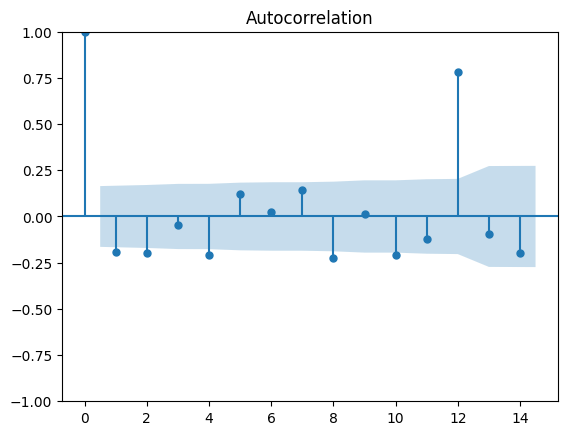

In [33]:
#Calculate Q value for Trend
plot_acf(dataset['2nd diff'].dropna(), lags=14)
plt.show()

In [34]:
# Trend : 
# p: 4 (No. of lines in partial auto correlation crossing the threshold. Thres = Blue ribbon. Stop counting the moment the first line falls below ribbon)
#       Within ribbon, start counting lines that starts from the ribbon. Do not include lines outside ribbon
# d: 2 (No. of attempts taken to get nominal p value)
# q: 2

# Seasonality
# P: 
# D: 1
# Q:

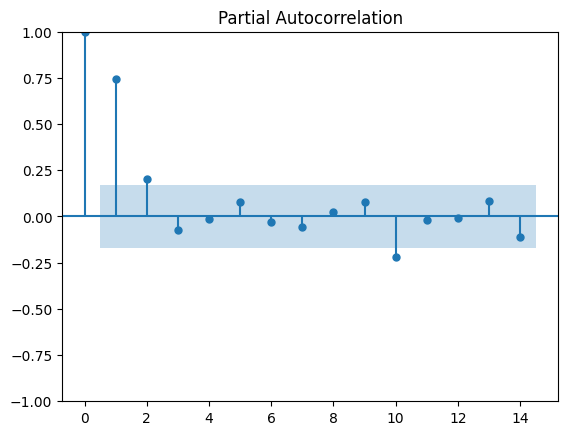

In [35]:
#Seasonality
plot_pacf(dataset['Seasonality'].dropna(), lags=14)
plt.show()

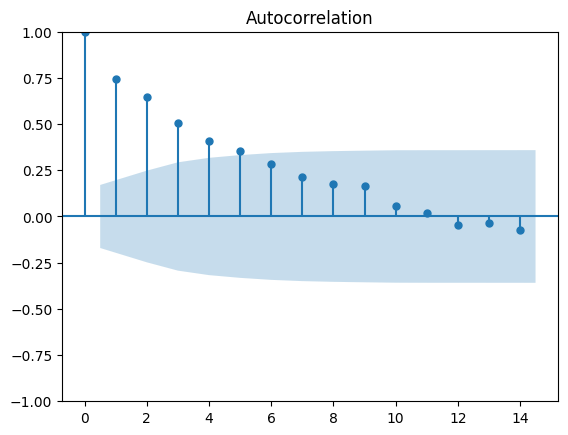

In [36]:
plot_acf(dataset['Seasonality'].dropna(), lags=14)
plt.show()

In [37]:
# Trend : 
# p: 4 (No. of lines in partial auto correlation crossing the threshold. Thres = Blue ribbon. Stop counting the moment the first line falls below ribbon)
#       Within ribbon, start counting lines that starts from the ribbon. Do not include lines outside ribbon
# d: 2 (No. of attempts taken to get nominal p value)
# q: 2

# Seasonality
# P: 2
# D: 1
# Q: 5

# We now have both Trend and Seasonality values. We are ready to build model

In [ ]:
## NOTES ##

# AutoRegressive - AR(p) 
# Integrated I(d)
# Moving average MA(q)

# Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots: Examine these plots to identify significant lags. 
# ACF helps with MA terms, while PACF assists in determining AR terms.

## Model building - Time series forecasting (ARIMA) 

In [38]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [39]:
model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'], order=(4,2,2), seasonal_order=(2,1,5,12))
#x = with realtime external factors
# Using Sarima-X model here
# seasonal_order=(2,1,5,12) 12 because we are seeing seasonality every 12 months from graph

result = model.fit()
print(result.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82303D+00    |proj g|=  4.28376D-01


 This problem is unconstrained.



At iterate    5    f=  3.52239D+00    |proj g|=  2.76994D-02

At iterate   10    f=  3.46833D+00    |proj g|=  2.41587D-02

At iterate   15    f=  3.45826D+00    |proj g|=  1.21068D-02

At iterate   20    f=  3.45560D+00    |proj g|=  2.68788D-03

At iterate   25    f=  3.45451D+00    |proj g|=  3.39297D-03

At iterate   30    f=  3.45402D+00    |proj g|=  3.61897D-03

At iterate   35    f=  3.45151D+00    |proj g|=  2.81182D-02

At iterate   40    f=  3.44993D+00    |proj g|=  4.07440D-03

At iterate   45    f=  3.44973D+00    |proj g|=  6.51964D-03

At iterate   50    f=  3.44940D+00    |proj g|=  4.13928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:                          Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -496.714
Date:                                          Wed, 28 Feb 2024   AIC                           1021.428
Time:                                                  09:27:42   BIC                           1061.574
Sample:                                              01-01-1949   HQIC                          1037.741
                                                   - 12-01-1960                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

In [40]:
## Thumb rule: Check model and AIC value
# Lesser the AIC value, better the model 


# AIC: 1021.428      SARIMAX(4, 2, 2)x(2, 1, 5, 12)
# AIC: 1020.039     SARIMAX(4, 2, 2)x(2, 1, 4, 12)
# AIC: 1018.383     SARIMAX(4, 2, 2)x(2, 1, 3, 12)
# AIC: 1017.566     SARIMAX(4, 2, 2)x(2, 1, 2, 12)
# AIC: 1015.572     SARIMAX(4, 2, 2)x(2, 1, 1, 12) *** This is the best model



In [41]:
model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'], order=(4,2,2), seasonal_order=(2,1,4,12))
result = model.fit()
print(result.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82303D+00    |proj g|=  4.28376D-01

At iterate    5    f=  3.52858D+00    |proj g|=  2.72336D-02

At iterate   10    f=  3.47384D+00    |proj g|=  2.75035D-02

At iterate   15    f=  3.46072D+00    |proj g|=  9.15133D-03

At iterate   20    f=  3.45650D+00    |proj g|=  4.47566D-03

At iterate   25    f=  3.45592D+00    |proj g|=  8.10236D-03

At iterate   30    f=  3.45220D+00    |proj g|=  5.86420D-03

At iterate   35    f=  3.45162D+00    |proj g|=  1.20797D-03

At iterate   40    f=  3.45153D+00    |proj g|=  1.52629D-04

At iterate   45    f=  3.45153D+00    |proj g|=  9.31107D-05


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.45152D+00    |proj g|=  1.10203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     52      1     0     0   1.102D-03   3.452D+00
  F =   3.4515230782367583     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                           SARIMAX Results                                           
Dep. Variable:                       Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4], 12)   Log Likelihood                -497.019
Date:                                       Wed, 28 Feb

In [42]:
model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'], order=(4,2,2), seasonal_order=(2,1,3,12))
result = model.fit()
print(result.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84926D+00    |proj g|=  5.20040D-01


 This problem is unconstrained.



At iterate    5    f=  3.52980D+00    |proj g|=  2.43030D-02

At iterate   10    f=  3.47635D+00    |proj g|=  6.95061D-02

At iterate   15    f=  3.46065D+00    |proj g|=  1.02014D-02

At iterate   20    f=  3.45768D+00    |proj g|=  6.60772D-03

At iterate   25    f=  3.45463D+00    |proj g|=  6.42851D-03

At iterate   30    f=  3.45297D+00    |proj g|=  4.70975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     33     43      1     0     0   3.326D-03   3.453D+00
  F =   3.4527180646379612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                         SARIMAX Re

In [43]:
model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'], order=(4,2,2), seasonal_order=(2,1,2,12))
result = model.fit()
print(result.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83399D+00    |proj g|=  4.48165D-01

At iterate    5    f=  3.53289D+00    |proj g|=  2.41508D-02

At iterate   10    f=  3.49407D+00    |proj g|=  4.06831D-02

At iterate   15    f=  3.48827D+00    |proj g|=  3.16818D-02

At iterate   20    f=  3.47184D+00    |proj g|=  5.15093D-02

At iterate   25    f=  3.46385D+00    |proj g|=  6.02956D-03

At iterate   30    f=  3.46286D+00    |proj g|=  8.51318D-03

At iterate   35    f=  3.45743D+00    |proj g|=  1.76381D-02

At iterate   40    f=  3.45689D+00    |proj g|=  1.37948D-03

At iterate   45    f=  3.45683D+00    |proj g|=  7.57328D-04


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.45683D+00    |proj g|=  2.12715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     54      1     0     0   2.127D-04   3.457D+00
  F =   3.4568257487447411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:            Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, 2, 12)   Log Likelihood                -497.783
Date:                            Wed, 28 Feb 2024   AIC                           1017.5

In [44]:
model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'], order=(4,2,2), seasonal_order=(2,1,1,12))
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82440D+00    |proj g|=  4.74010D-01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.53230D+00    |proj g|=  2.97576D-02

At iterate   10    f=  3.49314D+00    |proj g|=  3.31745D-02

At iterate   15    f=  3.47530D+00    |proj g|=  2.65276D-02

At iterate   20    f=  3.46054D+00    |proj g|=  6.63224D-03

At iterate   25    f=  3.45820D+00    |proj g|=  4.04613D-03

At iterate   30    f=  3.45698D+00    |proj g|=  9.70288D-04

At iterate   35    f=  3.45690D+00    |proj g|=  4.08887D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.45686D+00    |proj g|=  8.86262D-04

At iterate   45    f=  3.45685D+00    |proj g|=  4.59004D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     75      2     0     0   3.122D-05   3.457D+00
  F =   3.4568464295587407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                       
Dep. Variable:              Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1], 12)   Log Likelihood                -497.786
Date:               

In [45]:
len(dataset)

144

In [46]:
# Prediction
dataset['Forecast'] = result.predict(start=130, end=144, dynamic=True)    #Predicting values for months 130 till 144

In [47]:
dataset.tail(20)

,Thousands of Passengers,1st diff,2nd diff,Seasonality,Forecast
Month,,,,,
1959-05-01,420,24.0,34.0,57.0,NaN
1959-06-01,472,52.0,28.0,37.0,NaN
1959-07-01,548,76.0,24.0,57.0,NaN
1959-08-01,559,11.0,-65.0,54.0,NaN
1959-09-01,463,-96.0,-107.0,59.0,NaN
1959-10-01,407,-56.0,40.0,48.0,NaN
1959-11-01,362,-45.0,11.0,52.0,355.666992
1959-12-01,405,43.0,88.0,68.0,388.257235
1960-01-01,417,12.0,-31.0,57.0,404.220964


<Axes: xlabel='Month'>

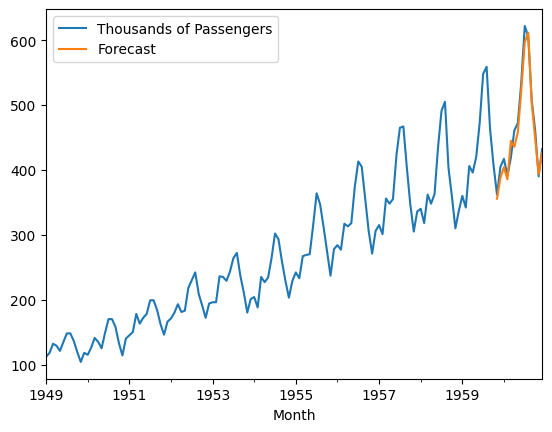

In [48]:
# Visualization
dataset[['Thousands of Passengers', 'Forecast']].plot()

In [49]:
# The model looks good.

# Prediction from 1961 to 1970

## Approach 2. Apply itertools - Iterative approach

In [50]:

import itertools

In [52]:
p= d= q= range(0,2)
pdq = list(itertools.product(p, d, q)) #Trend
seasonal_pdq = [(x[0], x[1], x[2], 12)for x in pdq] #Seasonality

print('Checking few parameters combinations are as follows: ')
print('{} X {}'.format(pdq[0], seasonal_pdq[0]))
print('{} X {}'.format(pdq[0], seasonal_pdq[1]))
print('{} X {}'.format(pdq[0], seasonal_pdq[2]))
print('{} X {}'.format(pdq[1], seasonal_pdq[0]))
print('{} X {}'.format(pdq[1], seasonal_pdq[1]))
print('{} X {}'.format(pdq[2], seasonal_pdq[0]))
print('{} X {}'.format(pdq[3], seasonal_pdq[2]))

Checking few parameters combinations are as follows: 
(0, 0, 0) X (0, 0, 0, 12)
(0, 0, 0) X (0, 0, 1, 12)
(0, 0, 0) X (0, 1, 0, 12)
(0, 0, 1) X (0, 0, 0, 12)
(0, 0, 1) X (0, 0, 1, 12)
(0, 1, 0) X (0, 0, 0, 12)
(0, 1, 1) X (0, 1, 0, 12)


In [53]:
print(len(pdq))
print(len(seasonal_pdq))

8
8


In [55]:
res_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'], 
                                              order=param,
                                                seasonal_order=param_seasonal, 
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False
                                                )
            result = model.fit()
            res='ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, result.aic)
            res_list.append(res)
            print(res)
        except:
            continue

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09179D+00    |proj g|=  1.97105D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   1.696D-06   7.092D+00
  F =   7.0917810716762455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC: 2044.4329486427587
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86606D+00    |proj g|=  1.39354D-01

At iterate    5    f=  3.83184D+00    |proj g|=  6.94733D-02

At iterate   10    f=  3.70296D+00    |proj g|=  2.89717D-02

At iterate   15    f=  3.70187D+00    |proj g|=  5.29181D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   5.292D-06   3.702D+00
  F =   3.7018690916820711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr


At iterate   10    f=  4.14225D+00    |proj g|=  1.06773D-01

At iterate   15    f=  4.13442D+00    |proj g|=  5.18483D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     23      1     0     0   1.291D-07   4.134D+00
  F =   4.1344201427012592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC: 1194.7130010979627
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55267D+00    |proj g|=  8.17257D-03

           * *

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr


At iterate   15    f=  4.08205D+00    |proj g|=  3.92717D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   3.927D-06   4.082D+00
  F =   4.0820518954025040     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC: 1181.630945875921
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48207D+00    |proj g|=  8.47786D-03

At iterate    5    f=  3.48196D+00    |proj g|=  5.82776D-03

           * * 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr

ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC: 934.7975425749117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17905D+00    |proj g|=  7.64607D-02

At iterate    5    f=  3.16815D+00    |proj g|=  1.48548D-02

At iterate   10    f=  3.16779D+00    |proj g|=  1.57721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   9.411D-06   3.168D+00
  F =   3.1677753385378331     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrain

ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC: 944.3854921533131
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09765D+00    |proj g|=  6.06800D-02

At iterate    5    f=  4.08511D+00    |proj g|=  6.98605D-02

At iterate   10    f=  4.03206D+00    |proj g|=  4.21233D-01

At iterate   15    f=  3.52989D+00    |proj g|=  1.13994D-01

At iterate   20    f=  3.51151D+00    |proj g|=  2.26701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     34      1     0     0   3.850D-0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr


At iterate   15    f=  3.26009D+00    |proj g|=  1.29203D-01

At iterate   20    f=  3.25619D+00    |proj g|=  8.62405D-03

At iterate   25    f=  3.25500D+00    |proj g|=  2.85651D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   1.340D-05   3.255D+00
  F =   3.2550003009760955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC: 945.4400866811155
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr


At iterate   20    f=  3.19942D+00    |proj g|=  3.51532D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   3.515D-06   3.199D+00
  F =   3.1994200374625619     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC: 929.4329707892178
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09075D+00    |proj g|=  1.76922D-01

At iterate    5    f=  4.03549D+00    |proj g|=  2.94982D-02

At iterate   10

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr

ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC: 935.8163348217239
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23276D+00    |proj g|=  3.23891D-01

At iterate    5    f=  3.21862D+00    |proj g|=  1.22467D-02

At iterate   10    f=  3.21743D+00    |proj g|=  3.03052D-02

At iterate   15    f=  3.21676D+00    |proj g|=  1.64663D-02

At iterate   20    f=  3.21504D+00    |proj g|=  1.28356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   1.876D-0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20574D+00    |proj g|=  8.39406D-02

At iterate    5    f=  3.20223D+00    |proj g|=  6.98477D-03

At iterate   10    f=  3.20184D+00    |proj g|=  3.98841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.378D-06   3.202D+00
  F =   3.2018447351755412     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC: 928.1312837305559
RUNNING THE L-BF

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr


At iterate   15    f=  3.19494D+00    |proj g|=  1.70108D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   5.274D-07   3.195D+00
  F =   3.1949370208977297     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC: 928.1418620185461
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78049D+00    |proj g|=  4.87980D-02

At iterate    5    f=  4.76417D+00    |proj g|=  6.76330D-02

At iterate   10

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, fr


At iterate    5    f=  4.01375D+00    |proj g|=  3.99190D-02

At iterate   10    f=  3.69893D+00    |proj g|=  1.16467D+00

At iterate   15    f=  3.47715D+00    |proj g|=  5.71209D-03

At iterate   20    f=  3.47639D+00    |proj g|=  1.29964D-02

At iterate   25    f=  3.47635D+00    |proj g|=  1.26698D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   1.267D-05   3.476D+00
  F =   3.4763528127370313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC: 1009.189610068265
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

In [59]:
print([i for i in res_list])

['ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC: 2044.4329486427587', 'ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC: 1887.3325916719614', 'ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC: 1315.9211929474204', 'ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC: 1156.291490150854', 'ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC: 1118.6259190717344', 'ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC: 1107.2562043228816', 'ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC: 1109.2437994445113', 'ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC: 1033.6172166730323', 'ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC: 1846.0789377571612', 'ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC: 1567.9916312319717', 'ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC: 1196.99836143998', 'ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC: 1072.1382984044365', 'ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC: 1071.0026812259484', 'ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC: 1049.580142108901', 'ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC: 1059.5112223290398', 'ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC: 985.3346478031843', 'ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC: 1405.0006612949667', 'ARIMA(0, 1, 0)x(0

In [60]:
# ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC: 920.6308317604677 is the best and lowest AIC value so far 

model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'], 
                                              order=(0, 1, 1),
                                                seasonal_order=(0, 1, 1, 12), 
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False
                                                )
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17864D+00    |proj g|=  7.47003D-02

At iterate    5    f=  3.17587D+00    |proj g|=  2.67320D-03

At iterate   10    f=  3.17580D+00    |proj g|=  2.53639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   1.607D-06   3.176D+00
  F =   3.1758014991683083     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


<Axes: xlabel='Month'>

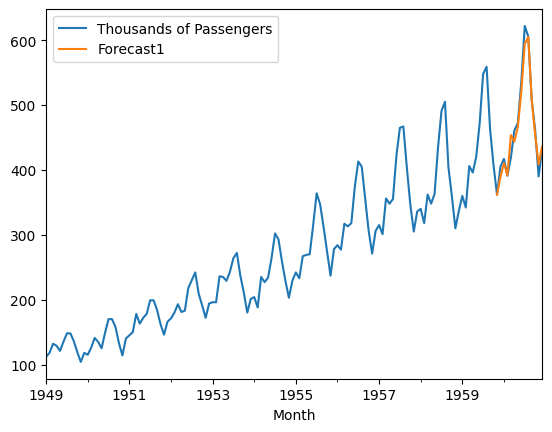

In [61]:
dataset['Forecast1'] = result.predict(start=130, end=144, dynamic=True) 
dataset[['Thousands of Passengers','Forecast1']].plot()

### Forecasting next 10 years

In [62]:
dataset.tail()

,Thousands of Passengers,1st diff,2nd diff,Seasonality,Forecast,Forecast1
Month,,,,,,
1960-08-01,606,-16.0,-103.0,47.0,611.529717,605.202758
1960-09-01,508,-98.0,-82.0,45.0,503.443659,509.141168
1960-10-01,461,-47.0,51.0,54.0,448.444883,454.238084
1960-11-01,390,-71.0,-24.0,28.0,393.173435,408.707968
1960-12-01,432,42.0,113.0,27.0,426.443102,436.213475


In [66]:
from pandas.tseries.offsets import DateOffset

future_date = [dataset.index[-1] +  DateOffset(months=x)for x in range(0, 121)]

In [65]:
dataset.index[-1]

Timestamp('1960-12-01 00:00:00')

In [67]:
future_date

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-

In [68]:
future_dates_df = pd.DataFrame(index=future_date[1:], columns=dataset.columns)
future_dates_df.tail()

,Thousands of Passengers,1st diff,2nd diff,Seasonality,Forecast,Forecast1
1970-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1970-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1970-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1970-11-01,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-01,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
len(future_dates_df)

120

In [70]:
len(dataset)

144

In [72]:
# Concatinating both dataframes
final_date = pd.concat([dataset, future_dates_df])
len(final_date)

264

In [73]:
final_date.tail(130)

,Thousands of Passengers,1st diff,2nd diff,Seasonality,Forecast,Forecast1
1960-03-01,419,28.0,54.0,13.0,444.884410,453.763015
1960-04-01,461,42.0,14.0,65.0,435.730182,443.396015
1960-05-01,472,11.0,-31.0,52.0,457.750956,466.281390
1960-06-01,535,63.0,52.0,63.0,522.612655,520.446116
1960-07-01,622,87.0,24.0,74.0,596.626250,594.032606
...,...,...,...,...,...,...
1970-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1970-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1970-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1970-11-01,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

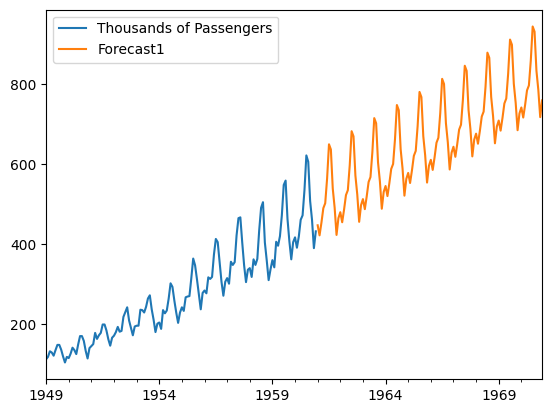

In [74]:
#Predict future passenger details and visulization

final_date['Forecast1'] = result.predict(start=144, end=264, dynamic=True)
final_date[['Thousands of Passengers', 'Forecast1']].plot()

In [75]:
final_date.tail(20)

,Thousands of Passengers,1st diff,2nd diff,Seasonality,Forecast,Forecast1
1969-05-01,NaN,NaN,NaN,NaN,NaN,764.242797
1969-06-01,NaN,NaN,NaN,NaN,NaN,826.250881
1969-07-01,NaN,NaN,NaN,NaN,NaN,911.744977
1969-08-01,NaN,NaN,NaN,NaN,NaN,898.795308
1969-09-01,NaN,NaN,NaN,NaN,NaN,801.012929
1969-10-01,NaN,NaN,NaN,NaN,NaN,753.125668
1969-11-01,NaN,NaN,NaN,NaN,NaN,685.005215
1969-12-01,NaN,NaN,NaN,NaN,NaN,726.922190
1970-01-01,NaN,NaN,NaN,NaN,NaN,741.866648
1970-02-01,NaN,NaN,NaN,NaN,NaN,716.726761


## Autoarima model

In [ ]:
!pip install pmdarima

In [76]:
from pmdarima import auto_arima

In [77]:
my_data = pd.read_csv('/Users/pawankumarkc/Documents/vscode_workspace/MLAlgo/datasets/TSForecasting/airline_passengers.csv')
my_data['Month'] = pd.to_datetime(my_data['Month'])
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [78]:
my_data.set_index('Month', inplace=True)
my_data.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [79]:
model = auto_arima(my_data, seasonal=True, m=12)
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Wed, 28 Feb 2024   AIC                           1017.847
Time:                                     10:42:41   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      

In [80]:
dataset1 = dataset.copy()

In [81]:
dataset1 = dataset1[['Thousands of Passengers','Forecast1']]
dataset1

,Thousands of Passengers,Forecast1
Month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1960-08-01,606,605.202758
1960-09-01,508,509.141168
1960-10-01,461,454.238084


In [82]:
dataset1 = dataset1.iloc[130:,:]
dataset1

,Thousands of Passengers,Forecast1
Month,,
1959-11-01,362,361.798306
1959-12-01,405,389.303813
1960-01-01,417,410.230434
1960-02-01,391,391.891692
1960-03-01,419,453.763015
1960-04-01,461,443.396015
1960-05-01,472,466.281390
1960-06-01,535,520.446116
1960-07-01,622,594.032606


In [83]:
actual_value = dataset1['Thousands of Passengers']
predicted_value = dataset1['Forecast1']

In [84]:
#Calculate MAPE

def calculate_mape(actuals, predicted):
    actuals, predicted = np.array(actuals), np.array(predicted)
    return np.mean(np.abs((actuals - predicted)/ actuals)) *100

In [86]:
mape = calculate_mape(actual_value, predicted_value)
print('MAPE :', mape)

MAPE : 2.4229727196754562
